In [77]:
# Import Necessary Libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import numpy as np
from yahoo_fin.stock_info import *
import pandas as pd
import numpy as np
import datetime
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import warnings
import seaborn as sns
from datetime import datetime, timedelta, date
import yfinance as yf
import pandas_market_calendars as mcal
from gekko import GEKKO

# Create a calendar for NYSE
nyse = mcal.get_calendar('NYSE')

# Ignore warnings from program
warnings.filterwarnings("ignore")


In [78]:
"""
Define functions to gather the indicators for each stock/pair
"""
def normalize(series):
    series = pd.Series(series)
    
    # Get the minimum and maximum values of the series.
    series.fillna(0, inplace = True)

    # Normalize the series by subtracting the minimum value and dividing by the range.
    return (series - series.mean()) / series.std()


# First indicator is the RSI, this is a continuous score, works for time series
def getRSI(stock, window):
    # First we must calculate the price differences day over day
    diff = stock.diff()

    # Now we find the gains and losses using clip()
    winners = diff.clip(lower=0)
    losers = diff.clip(upper=0).abs()

    # Calculate mean of winners and losers using simple moving average
    mean_win = winners.rolling(window).mean()
    mean_loss = losers.rolling(window).mean().abs()

    # Calculate RS and return RSI
    rs = mean_win / mean_loss
    return 100 - (100 / (1 + rs))


# Get the continuous Volume Weighted Average Price
def getVWAP(stock):
    # Get all historical values of the stock's volume
    quant = stock["volume"].values

    # Get all historical values of average price of stock
    price = ((stock["close"] + stock["high"] + stock["low"]) / 3).values

    # Calculate VWAP
    vwap = (price * quant).cumsum() / quant.cumsum()

    # Return VWAP
    return vwap


# This function calculates the simple moving average of a given time frame
def calc_avg(changes, window_size):
    windows = changes.rolling(window_size)
    moving_avg = windows.mean()
    moving_avg_lst = moving_avg.values.tolist()
    final_list = moving_avg_lst[window_size - 1:]
    final_index = changes.index[window_size - 1:]
    return pd.Series(final_list, final_index)


def sharpe(stock):
    # Begin with 5-year t-bill rate from 2/16/2018, the start of our portfolio, yearly expected return
    rfr = 2.67 * (1 / np.sqrt(5))

    # to calculate sharpe ratio, we follow the formula (return - rfr) / standard deviation
    return round(((np.mean(stock) - rfr) / np.std(stock)) * np.sqrt(5), 2)

def downside_deviation(series, threshold):
    # Calculate returns below the threshold
    below_threshold = series[series < threshold]
    
    # Calculate squared deviations from the threshold
    squared_deviations = (below_threshold - threshold) ** 2
    
    # Calculate the mean of squared deviations
    mean_squared_deviations = squared_deviations.mean()
    
    # Calculate the square root to get the downside deviation
    downside_dev = np.sqrt(mean_squared_deviations)
    
    return downside_dev

# This is a function that will track the mean spread of the two stocks over time, this should hopefully help our algorithm a lot in finding entry and exit points

def cumulative_mean(lst):
    result = []
    for i in range(1, len(lst) + 1):
        subset_list = lst[:i]
        mean_value = sum(subset_list) / len(subset_list)
        result.append(mean_value)
    return result

def cumulative_vol(lst):
    result = []
    for i in range(1, len(lst) + 1):
        subset_list = lst[:i]
        std_value = np.std(subset_list)
        result.append(std_value)
    return result

In [94]:
# Define the start and end dates of our data collection using datetime
# These are constant variables, adjust them here if necessary
start_date = date(year=2010, month=1, day=1)
end_date = date(year=2023, month=12, day=3)

# Specify the split point (e.g., a specific date) as a datetime object
split_date = pd.to_datetime(date(year=2021, month=1, day=1))

# Forward prediction period
n_ahead_pred = 63

In [119]:
def construct(stock, n_days):
    # Get the data from each given stock from yahoo_fin
    try:
        stock_data = get_data(stock.strip(), start_date, end_date)
        SPY = get_data("SPY", start_date, end_date)
    except AssertionError as e:
        print(f"Error fetching data for pair {stock1}, {stock2}: {e}")
        return 0
    
    # Ensure the index is a DatetimeIndex
    if not isinstance(stock_data.index, pd.DatetimeIndex):
        stock_data['Date'] = pd.to_datetime(stock_data['date'])
        stock_data.set_index('Date', inplace=True)

    df = pd.DataFrame()
    
    df["Stock"] = stock_data["adjclose"]
    df["High"] = normalize(stock_data["high"])
    df["Low"] = normalize(stock_data["low"])
    df["Open"] = normalize(stock_data["open"])
    df["volume"] = normalize(stock_data["volume"])
    df["High v Low"] = normalize(stock_data["high"] - stock_data["low"])
    df["Close v Open"] = normalize(stock_data["adjclose"] - stock_data["open"])
    df["Daily LGReturn"] = np.log1p(stock_data["adjclose"].pct_change())
    df["N_days LGReturn"] = np.log1p(stock_data["adjclose"].pct_change(n_days))
    df["RD2"] = df["N_days LGReturn"].diff()
    df["RD3"] = df["RD2"].diff()
    df["10 MA"] = calc_avg(df["Stock"], 10)
    df["20 MA"] = calc_avg(df["Stock"], 20)
    df["50 MA"] = calc_avg(df["Stock"], 50)
    df["100 MA"] = calc_avg(df["Stock"], 100)
    df["200 MA"] = calc_avg(df["Stock"], 200)
    df["10 MV"] = calc_avg(df["volume"], 10)
    df["20 MV"] = calc_avg(df["volume"], 20)
    df["50 MV"] = calc_avg(df["volume"], 50)
    df["100 MV"] = calc_avg(df["volume"], 100)
    df["200 MV"] = calc_avg(df["volume"], 200)
    df["10D volatility"] = normalize(df["Stock"].rolling(10).std()*(252**0.5))
    df["20D volatility"] = normalize(df["Stock"].rolling(20).std()*(252**0.5))
    df["50D volatility"] = normalize(df["Stock"].rolling(50).std()*(252**0.5))
    df["100D volatility"] = normalize(df["Stock"].rolling(100).std()*(252**0.5))
    df["200D volatility"] = normalize(df["Stock"].rolling(200).std()*(252**0.5))
    df["RSI"] = getRSI(stock_data["adjclose"], 14)
    df["RSI2"] = getRSI(stock_data["adjclose"], n_days)
    
    df["SPY"] = SPY["adjclose"]
    df["SPY High"] = normalize(SPY["high"])
    df["SPY Low"] = normalize(SPY["low"])
    df["SPY Open"] = normalize(SPY["open"])
    df["SPY volume"] = normalize(SPY["volume"])
    df["SPY High v Low"] = normalize(SPY["high"] - SPY["low"])
    df["SPY Close v Open"] = normalize(SPY["adjclose"] - SPY["open"])
    df["SPY Daily LGReturn"] = np.log1p(SPY["adjclose"].pct_change())
    df["SPY N_days LGReturn"] = np.log1p(SPY["adjclose"].pct_change(n_days))
    df["SPY RD2"] = df["SPY N_days LGReturn"].diff()
    df["SPY RD3"] = df["SPY RD2"].diff()
    df["SPY 10 MA"] = calc_avg(df["SPY"], 10)
    df["SPY 20 MA"] = calc_avg(df["SPY"], 20)
    df["SPY 50 MA"] = calc_avg(df["SPY"], 50)
    df["SPY 100 MA"] = calc_avg(df["SPY"], 100)
    df["SPY 200 MA"] = calc_avg(df["SPY"], 200)
    df["SPY 10 MV"] = calc_avg(df["SPY volume"], 10)
    df["SPY 20 MV"] = calc_avg(df["SPY volume"], 20)
    df["SPY 50 MV"] = calc_avg(df["SPY volume"], 50)
    df["SPY 100 MV"] = calc_avg(df["SPY volume"], 100)
    df["SPY 200 MV"] = calc_avg(df["SPY volume"], 200)
    df["SPY 10D volatility"] = normalize(df["SPY"].rolling(10).std()*(252**0.5))
    df["SPY 20D volatility"] = normalize(df["SPY"].rolling(20).std()*(252**0.5))
    df["SPY 50D volatility"] = normalize(df["SPY"].rolling(50).std()*(252**0.5))
    df["SPY 100D volatility"] = normalize(df["SPY"].rolling(100).std()*(252**0.5))
    df["SPY 200D volatility"] = normalize(df["SPY"].rolling(200).std()*(252**0.5))
    df["SPY RSI"] = getRSI(SPY["adjclose"], 14)
    df["SPY RSI2"] = getRSI(SPY["adjclose"], n_days)
    
    df = df.iloc[::n_days]
    
    df["Stock Lag 1"] = df["Stock"].shift(1)
    df["Stock Lag 2"] = df["Stock"].shift(2)
    df["Stock Lag 3"] = df["Stock"].shift(3)
    df["Return Lag 1"] = df["N_days LGReturn"].shift(1)
    df["Return Lag 2"] = df["N_days LGReturn"].shift(2)
    df["Return Lag 3"] = df["N_days LGReturn"].shift(3)
    
    df["SPY Lag 1"] = df["SPY"].shift(1)
    df["SPY Lag 2"] = df["SPY"].shift(2)
    df["SPY Lag 3"] = df["SPY"].shift(3)
    df["SPY Return Lag 1"] = df["SPY N_days LGReturn"].shift(1)
    df["SPY Return Lag 2"] = df["SPY N_days LGReturn"].shift(2)
    df["SPY Return Lag 3"] = df["SPY N_days LGReturn"].shift(3)
    
    df["return spread"] = (df["N_days LGReturn"] - df["SPY N_days LGReturn"])
    #df["RS-Mean"] = cumulative_mean(df["return spread"])
    #df["Distance"] = df["RS-Mean"] - df["return spread"]
    #df["DD1"] = df["Distance"].diff()
    #df["DD2"] = df["DD1"].diff()
    #df["DD3"] = df["DD2"].diff()
    df["SD"] = df["return spread"].diff()  # First derivative of spread, change in spread
    df["S2D"] = df["SD"].diff()  # Second Derivative, concavity of spread
    df["S3D"] = df["S2D"].diff()  # Third Derivative, concavity of change in spread
    
    # Return the dataframe - NaN values from first day
    return df[(200//63 +1):]

In [81]:
# Create function to split train and test
def split_data(df, split_date):
    # Add next day spread to dataframe and remove
    df["y"] = df["return spread"].shift(-1)
    df = df[:-1]

    # Filter the data into training and testing sets
    train_data = df[df.index < split_date]
    test_data = df[df.index >= split_date]
    
    test_data = test_data.reset_index(drop = True)
    
    test_data = test_data.iloc[:1]

    # Separate the features (X) and target (y) for both sets
    y_train = train_data["y"]
    X_train = train_data.drop(columns=["y"])

    y_test = test_data["y"]
    X_test = test_data.drop(columns=["y"])
    
    
    return X_train, y_train, X_test, y_test

In [82]:
def fake_split(df, split_date):
    test_data = df[df.index >= split_date]
    
    return len(test_data)

In [123]:
def train_mod(stock, split_date):
    X_train, y_train, X_test, y_test = split_data(stock, split_date)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    
    return prediction, y_test, y_train
    
    

In [135]:
basket = ["VGT", "VNQ", "XLF", "XLV", "XLE", "XLI", "XLY", "XLP", "XLU", "XLB", "VOX", "GLD", "SPAB"]
top5 =["AAPL", "MSFT", "GOOG", "AMZN", "NVDA"]

In [144]:
def train_mod(stock, split_date):
    # Define a dictionary with the hyperparameter grid
    X_train, y_train, X_test, y_test = split_data(stock, split_date)
    
    """
    param_grid = {
        'max_depth': [100],  # Max depth of trees
        'learning_rate': [.5],
        'n_estimators': [1000],
        'subsample': [1],
        'colsample_bytree': [1],
        'colsample_bylevel': [1],
        'min_child_weight': [14]
    }
    """
    param_grid = {
        'max_depth': list(range(10, 1001, 20)),  # Max depth of trees
        'learning_rate': [i / 100 for i in range(1, 100, 5)],
        'n_estimators': list(range(10, 1001, 20)),
        'subsample': [i / 100 for i in range(60, 101, 5)],
        'colsample_bytree': [i / 100 for i in range(60, 101, 5)],
        'colsample_bylevel': [i / 100 for i in range(60, 101, 5)],
        'min_child_weight': list(range(0, 51, 5))
    }
    #"""
    # Create an XGBoost regressor model, uses squared error as the error parameter
    model = xgb.XGBRegressor(objective="reg:squarederror", 
                             device="cuda", 
                             validate_parameters=True, 
                             early_stopping_rounds=20,
                             tree_method = 'exact')
    
    # Create a GridSearchCV object
    random_search = RandomizedSearchCV(
        estimator = model,
        param_distributions = param_grid,  # Use param_grid instead of param_distributions
        scoring = "neg_mean_squared_error",  # Choose an appropriate scoring metric
        cv = 5,  # Number of cross-validation folds
        verbose = 0,
        n_jobs = -1,  # Use all available CPU cores
        n_iter = 25
    )
    
    try:
        random_search.fit(X_train, y_train, 
                        eval_set=[(X_train, y_train)], 
                        verbose=False
                        )
    except ValueError:
        return 0

    # Get the best hyperparameters and model
    best_params = random_search.best_params_
    best_model = random_search.best_estimator_
    best_model.save_model("301-model.json")
    
    # Make predictions with the best model
    prediction = best_model.predict(X_test)
    
    #xgb.plot_importance(best_model)
    #plt.show()
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_test, prediction)
    
    error = mse ** 0.5
    
    mape = np.mean(np.abs((y_test - prediction) / y_test)) * 100
    
    #plt.plot(y_test.index, normalize(prediction), label = "predictions")
    #plt.plot(y_test.index, normalize(y_test), label = "actual")
    #plt.legend()
    #plt.show()
    
    # Print the best hyperparameters and MSE
    #print("Best Hyperparameters:", best_params)
    #print("Standard Error:", mse ** 0.5)
    
    return prediction, y_test, y_train


#df = construct(top5[1], n_ahead_pred)
#train_mod(df, split_date)

In [145]:
def get_expected_rtrn(predicted_rtrns, i):
    return predicted_rtrns[i][len(predicted_rtrns) - 1]

def get_covariance(cov, i, j):
    return cov[i][j]

In [146]:
def find_max_sharpe_ratio(pareto_frontier, risk_free_rate=0.005):
    max_sharpe_ratio = -1
    optimal_weights = None

    for point in pareto_frontier:
        portfolio_return, portfolio_risk, asset_weights = point
        if portfolio_risk != 0:  # To avoid division by zero
            # Calculate Sharpe Ratio
            sharpe_ratio = (portfolio_return - risk_free_rate) / abs(portfolio_risk)
            if sharpe_ratio > max_sharpe_ratio:
                max_sharpe_ratio = sharpe_ratio
                optimal_weights = asset_weights

    return optimal_weights

In [147]:
def get_predictions(assets, split_date):
    
    pred_rtrns = pd.DataFrame()
    
    for i, item in enumerate(assets):
        print(i * ".")
        df = construct(item, n_ahead_pred)
    
        prediction, actual, y_train = train_mod(df, split_date)
    
        pred_rtrns[item] = pd.concat([y_train, pd.Series(prediction[0])])
        
    pred_rtrns = pred_rtrns.reset_index(drop = True)
        
    return pred_rtrns      


.
..
...
....


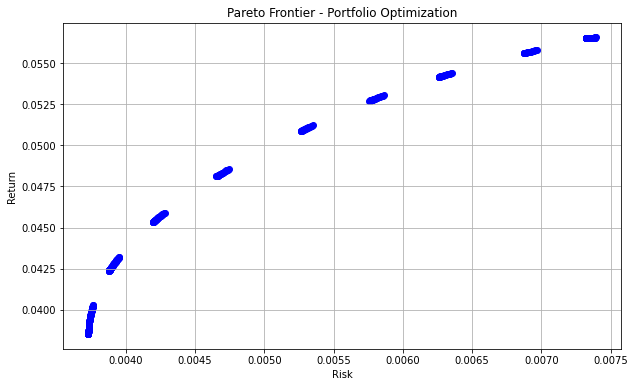

In [148]:
def construct_pareto_frontier(assets, split_date):
    
    predicted_rtrns = get_predictions(assets, split_date)
    
    covariance_matrix = predicted_rtrns.cov()
    
    # Initialize GEKKO model
    m = GEKKO(remote=False)
   
    w1 = m.Param(value=1.0)
    w2 = m.Param(value=1.0 - w1)
    
    # Variables
    X = {asset: m.Var(lb=0, ub=1, name=asset) for asset in assets}
    
    # Parameters for expected returns and covariances
    r = {asset: get_expected_rtrn(predicted_rtrns, asset) for asset in assets}
   
    cov_params = {(i, j): get_covariance(covariance_matrix, i, j) for i in assets for j in assets}
    
    # Weights for objectives as GEKKO parameters
    
    # Constraint: Sum of X values equal to 1
    m.Equation(sum([X[asset] for asset in assets]) == 1)
    
    # Objective functions
    obj1 = sum([X[asset] * r[asset] for asset in assets]) # Return
    obj2 = - sum([X[i] * X[j] * cov_params[i, j] for i in assets for j in assets]) # Risk
    
    # Combined Objective
    m.Maximize(w1 * obj1 + w2 * obj2)
    
    # Solve the optimization problem
    m.solve(disp=False)
    
    w_list = (np.logspace(0, 1.0, 501, base = 10) - 1) / 10
    
    pareto_frontier = []

    # Iterate over a set of weights
    for w in w_list:
        # Set the weights for the objectives
        w1.value = w
        w2.value = 1 - w
        
        # Solve the model
        m.solve(disp=False)

        # Calculate return and risk
        portfolio_return = sum([X[asset].value[0] * r[asset] for asset in assets])
        portfolio_risk = - sum([X[i].value[0] * X[j].value[0] * cov_params[i, j] for i in assets for j in assets])

        # Collect the weights
        asset_weights = [X[asset].value[0] for asset in assets]

        # Add to the Pareto frontier
        pareto_frontier.append((portfolio_return, portfolio_risk, asset_weights))

    return pareto_frontier



# Example of Function
pareto_frontier = construct_pareto_frontier(top5, split_date)

returns = [point[0] for point in pareto_frontier]
risks = [abs(point[1]) for point in pareto_frontier]

# Plotting the Pareto frontier
plt.figure(figsize=(10, 6))
plt.scatter(risks, returns, c='blue', marker='o')  # Scatter plot
#plt.plot(risks, returns, 'b-')  # Use this for a line plot

# Customizing the plot
plt.title('Pareto Frontier - Portfolio Optimization')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.grid(True)

# Show the plot
plt.show()


In [149]:
def period_rtrn(assets, capital, allocations, n_days, length):
    
    rtrns = []
    
    for i, item in enumerate(assets):
        df = construct(item, n_days)
        
        df = df.reset_index(drop = True)
        
        rtrn = (capital * allocations[i]) * (((df["Stock"][len(df["Stock"])- (length-1)]) /
                                                 (df["Stock"][len(df["Stock"]) - length])) - 1)
        
        rtrns.append(rtrn)

    return capital + sum(rtrns)

In [150]:
def backtest(assets, split_date, capital, test, n_days):
    length = test
    cap = [capital]
    k = 0

    while length > 1:
        print(k, "Months, Capital: $", round(cap[-1], 4))
        
        allocations = find_max_sharpe_ratio(construct_pareto_frontier(assets, split_date), 0.005)
        
        cap.append(period_rtrn(assets, cap[-1], allocations, n_days, length))
        
        holder_date = split_date+ pd.DateOffset(days = n_days * 2) 
        
        market_days = nyse.valid_days(start_date=split_date, end_date=holder_date)
 
        twenty_business_days_later = market_days[n_days - 1]

        split_date = np.datetime64(twenty_business_days_later.to_pydatetime())
        
        length -= 1
        k += 1
        
    return cap

In [ ]:
portfolio_rtrns = backtest(basket, split_date, 1000, fake_split(construct("AAPL", n_ahead_pred), split_date), n_ahead_pred)

In [129]:
print(portfolio_rtrns)

linRegRtrns = portfolio_rtrns

[1000, 1128.2591652166927, 1220.2168613233468, 1294.231521749265, 1297.8017643934527, 1382.7975963021513, 1333.4188692777975, 1150.992319844415, 1100.3210938025875, 1184.9713752560353, 1253.7308186458752, 1366.1469039504564]


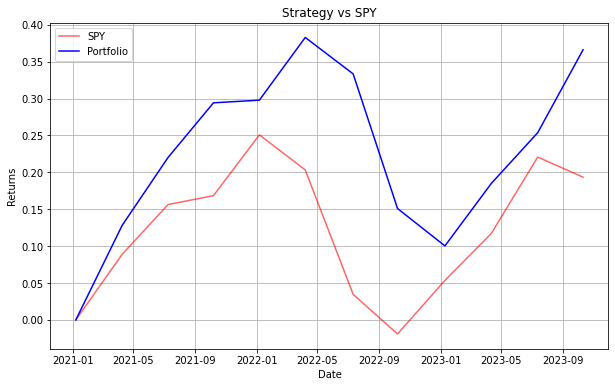

In [132]:
SPY = construct("AAPL", n_ahead_pred)["SPY"][-(fake_split(construct("AAPL", n_ahead_pred),
                           pd.to_datetime(date(year=2021, month=1, day=1)))):]


SPY = (SPY / SPY.iloc[0]) - 1
port_returns = pd.Series(portfolio_rtrns)
plot_returns = (port_returns / port_returns.iloc[0]) - 1

plt.figure(figsize=(10, 6))
plt.plot(SPY.index, SPY, color = "red", alpha = 0.6, label = "SPY")
plt.plot(SPY.index, plot_returns, color = "blue", label = "Portfolio")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("Strategy vs SPY")
plt.grid(True)
plt.legend()
plt.show()

